In [2]:
'''

Author: Madhav Sachdeva
Recent changes date: 5 March, 2022
Title: Helper functions for extracting features from sensor data

'''

import numpy as np
import pandas as pd
import os
from scipy import stats

In [3]:
#Global variable for path

folder_path = "../data/EmoCon/e4_data"
emotion_data_path = "../data/EmoCon/emotion_annotations/self_annotations/"

In [4]:
# Defining outlier removal methods

def remove_outliers_acc(data,column,z):
    
    '''
    Removing outliers 'z' (integer) standard deviation away from mean
    
    Input: data: Pandas DataFrame
    Output: outlier_removed_data: DataFrame with outliers removed

    '''
    
    #print("Data shape before", data[column].shape)
    if np.std(data[column]) != 0:
        outlier_removed_data = data[(np.abs(stats.zscore(data[column])) < z)] 
        
    #print("Data shape after:",outlier_removed_data[column].shape)

    return(outlier_removed_data)


def remove_outliers_heart_rate(data,column):
    
     
    '''
    Removing outliers with heart rate beats per minute <30 and >300
    
    Input: data: Pandas DataFrame
    Output: outlier_removed_data: DataFrame with outliers removed

    '''
    
    #print("Data shape before", data[column].shape)
    if np.std(data[column]) != 0:
        outlier_removed_data = data[data[column].iloc[:].between(30,300,inclusive=False)] 
        
    #print("Data shape after:",outlier_removed_data[column].shape)
    return(outlier_removed_data)

In [5]:
# Reading start and end durations
duration = pd.read_csv("../data/EmoCon/metadata/subjects.csv")
duration['initTime'] = pd.to_datetime(duration['initTime'],unit='ms')
duration['startTime'] = pd.to_datetime(duration['startTime'],unit='ms')
duration['endTime'] = pd.to_datetime(duration['endTime'],unit='ms')

In [80]:


def heart_rate_features(folder_path, sampling_rate,save_data_individually=False):
    """Obtain features from heart rate data.
    
    Args:
        folder_path(str): Path to the main folder.
        sampling_rate: Rate at which to sample and calculate statistics
        save_data_individually: Save each feature matrix per participant
        
    Returns:
        Data frame with features: Count, Mean, Std, Min, Q1, Median, Q3, Max, Skewness, Kurtosis, Range
    """
    features = []
    i = 0
    for subdir in os.listdir(folder_path):
        i+= 1
        for files in os.listdir(os.path.join(folder_path,subdir)):
            
            filepath = os.path.join(folder_path,subdir,files)

            #Check if heart_rate file exists, read data and find statistics - create a list with name
            if filepath.endswith("HR.csv"):

                #Reading emotion labels and creating timestamp based on participant's debate times
                emotion_label = pd.read_csv(emotion_data_path+"P"+str(subdir)+".self.csv",usecols=[0,1,2])
                emotion_label['timestamp'] = duration[duration['pid']==int(subdir)].startTime.iloc[0] + pd.to_timedelta(emotion_label['seconds'],'s')
                
                #Reading heart rate and converting timestamp to readable format
                heart_rate_raw = pd.read_csv(filepath, usecols=['timestamp', 'pid','value', 'device_serial'],header=0)
                heart_rate_raw['timestamp'] =  pd.to_datetime(heart_rate_raw['timestamp'],unit='ms')
                
                # Removing incorrect device serial from 29, 30, 31, 32
                if (subdir == "29" or subdir == "31"):
                    print("Before", subdir, heart_rate_raw.shape)
                    heart_rate_raw = heart_rate_raw.loc[heart_rate_raw.device_serial == "A013E1"]
                    print("After", subdir,heart_rate_raw.shape)
                elif (subdir == "30" or subdir == "32"): 
                    heart_rate_raw = heart_rate_raw.loc[heart_rate_raw.device_serial == "A01A3A"]
                    
                #Removing outliers
                heart_rate_outliers_removed = remove_outliers_heart_rate(heart_rate_raw,"value")
                # print("Removing outliers shape", subdir, heart_rate_outliers_removed.shape)
                
                #Keeping only data that is within the debate start and stop times
                start = duration[duration['pid']==int(subdir)].startTime.iloc[0]
                end = duration[duration['pid']==int(subdir)].endTime.iloc[0]
                start_time = str(start.time())

                heart_rate = heart_rate_outliers_removed[(heart_rate_outliers_removed['timestamp'] >= start) & (heart_rate_outliers_removed['timestamp'] <= end)]
                # print("heart rate shape", subdir, heart_rate)
                
                #Grouping samples in 5 second time windows (to match with emotion label annotation frequency) and generating statistics. Timestamp label in grouper is the last timestamp.
                rolling_df = heart_rate[['timestamp','value']].groupby(pd.Grouper(key='timestamp',freq='5S', offset=start_time, closed='right',label='right')).describe()
                rolling_df = rolling_df.droplevel(level=0,axis=1) # Dropping the extra labels
                rolling_df['data_range'] = rolling_df['max'] - rolling_df['min']
                rolling_df['skewness'] = heart_rate[['timestamp','value']].groupby(pd.Grouper(key='timestamp',offset=start_time, freq='5S', closed='right',label='right')).skew()
                rolling_df['kurtosis'] = heart_rate[['timestamp','value']].groupby(pd.Grouper(key='timestamp',offset=start_time, freq='5S', closed='right',label='right')).apply(pd.DataFrame.kurtosis)
                rolling_df['pid'] = heart_rate['pid'].iloc[0]

                #Merging emotion label data
                hr_emotion_labels = pd.merge(emotion_label[['timestamp','arousal','valence']], rolling_df, on='timestamp')
                hr_emotion_labels = hr_emotion_labels[(hr_emotion_labels['timestamp'] >= start) & (hr_emotion_labels['timestamp'] <= end)]

                #Binarize emotion label
                hr_emotion_labels['arousal_bin'] = hr_emotion_labels['arousal'].apply(lambda x:0 if x < 3 else 1)
                hr_emotion_labels['valence_bin'] = hr_emotion_labels['valence'].apply(lambda x:0 if x < 3 else 1)

                print("Participant:", subdir)
                print("Before removing", hr_emotion_labels.shape[0])
                    
                #Removing rows which have less than 5 seconds of samples
                # hr_emotion_labels = hr_emotion_labels.drop(hr_emotion_labels[hr_emotion_labels['count'] < sampling_rate].index)
                
                print("After removing", hr_emotion_labels.shape[0])
                
                #Saving features in list
                features.append(hr_emotion_labels)
                

            if(save_data_individually):
                hr_emotion_labels.to_csv('heart_rate_features_'+subdir+'.csv',index=False)
                print("Saving data for pid",subdir)
                
        
        #Combine features from all pids
        features_final = pd.concat(features)
        features_final = features_final.reset_index(drop=True)
        
    return features_final
               

In [6]:
import matplotlib.pyplot as plt

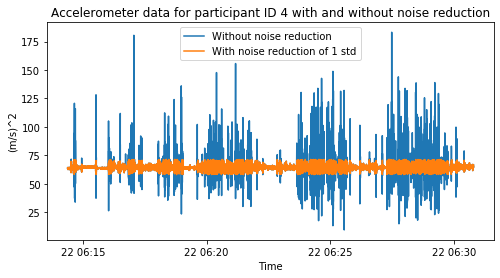

In [17]:
features = []
i = 0
subdir = "4"
for files in os.listdir(os.path.join(folder_path,subdir)):

    filepath = os.path.join(folder_path,subdir,files)

    #Check if acc file, read data and find statistics - create a list with name
    if filepath.endswith("ACC.csv"):

            #Reading emotion labels and creating timestamp based on participant's debate times
            emotion_label = pd.read_csv(emotion_data_path+"P"+str(subdir)+".self.csv",usecols=[0,1,2])
            emotion_label['timestamp'] = duration[duration['pid']==int(subdir)].startTime.iloc[0] + pd.to_timedelta(emotion_label['seconds'],'s')

            #Reading data and converting timestamp to readable format
            data_raw = pd.read_csv(filepath, usecols=['timestamp', 'pid','x','y','z', 'device_serial'],header=0)
            data_raw['timestamp'] =  pd.to_datetime(data_raw['timestamp'],unit='ms')

            #Merging accelerometer (x,y,z) positional data to represent in one value
            data_raw['m'] = data_raw.apply(lambda row: np.sqrt(row['x']**2 + row['y']**2 + row['z']**2), axis=1)

            # Removing incorrect device serial from 29, 30, 31, 32
            if (subdir == "29" or subdir == "31"):
                print("Before", subdir, data_raw.shape)
                data_raw = data_raw.loc[data_raw.device_serial == "A013E1"]
                print("After", subdir,data_raw.shape)
            elif (subdir == "30" or subdir == "32"): 
                data_raw = data_raw.loc[data_raw.device_serial == "A01A3A"]

            #Removing outliers
            data_raw_outliers_removed = remove_outliers_acc(data_raw,"m",1)
                
            # Plotting
            plt.figure(figsize=(8,4))
            plt.plot(data_raw['timestamp'],data_raw['m'], label="Without noise reduction")
            plt.title("Accelerometer data for participant ID "+subdir+" with and without noise reduction")
            plt.xlabel("Time")
            plt.ylabel("(m/s)^2")
            
            plt.plot(data_raw_outliers_removed['timestamp'],data_raw_outliers_removed['m'], label="With noise reduction of 1 std")
            plt.legend()

C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


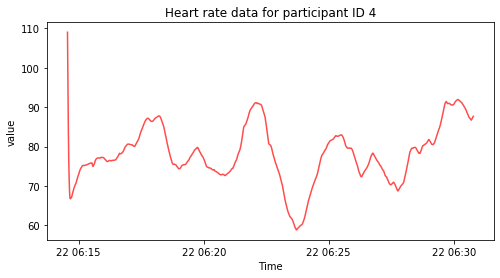

In [22]:
features = []
i = 0
subdir = "4"
for files in os.listdir(os.path.join(folder_path,subdir)):

    filepath = os.path.join(folder_path,subdir,files)

    #Check if acc file, read data and find statistics - create a list with name
    if filepath.endswith("HR.csv"):

            #Reading emotion labels and creating timestamp based on participant's debate times
            emotion_label = pd.read_csv(emotion_data_path+"P"+str(subdir)+".self.csv",usecols=[0,1,2])
            emotion_label['timestamp'] = duration[duration['pid']==int(subdir)].startTime.iloc[0] + pd.to_timedelta(emotion_label['seconds'],'s')

            #Reading heart rate and converting timestamp to readable format
            heart_rate_raw = pd.read_csv(filepath, usecols=['timestamp', 'pid','value', 'device_serial'],header=0)
            heart_rate_raw['timestamp'] =  pd.to_datetime(heart_rate_raw['timestamp'],unit='ms')

            #Removing outliers
            heart_rate_outliers_removed = remove_outliers_heart_rate(heart_rate_raw,"value")
                
            # Plotting
            plt.figure(figsize=(8,4))
            plt.plot(heart_rate_raw['timestamp'],heart_rate_raw['value'], label="Without noise reduction", color="red", alpha=0.7)
            plt.title("Heart rate data for participant ID "+subdir)
            plt.xlabel("Time")
            plt.ylabel("value")
#             plt.legend()

In [98]:
def accelerometer_features(folder_path,sampling_rate,save_data_individually=False):
    
    """Obtain features from accelerometer data.
    
    Args:
        folder_path(str): Path to the main folder.
        sampling_rate: Rate at which to sample and calculate statistics
        save_data_individually: Save each feature matrix per participant
        
    Returns:
        Data frame with features: Count, Mean, Std, Min, Q1, Median, Q3, Max, Skewness, Kurtosis, Range
    """
    
    features = []
    i = 0
    for subdir in os.listdir(folder_path):
        i+= 1
        for files in os.listdir(os.path.join(folder_path,subdir)):
            
            filepath = os.path.join(folder_path,subdir,files)

            #Check if acc file, read data and find statistics - create a list with name
            if filepath.endswith("ACC.csv"):
                
                    #Reading emotion labels and creating timestamp based on participant's debate times
                    emotion_label = pd.read_csv(emotion_data_path+"P"+str(subdir)+".self.csv",usecols=[0,1,2])
                    emotion_label['timestamp'] = duration[duration['pid']==int(subdir)].startTime.iloc[0] + pd.to_timedelta(emotion_label['seconds'],'s')
                    
                    #Reading data and converting timestamp to readable format
                    data_raw = pd.read_csv(filepath, usecols=['timestamp', 'pid','x','y','z', 'device_serial'],header=0)
                    data_raw['timestamp'] =  pd.to_datetime(data_raw['timestamp'],unit='ms')
                    
                    #Merging accelerometer (x,y,z) positional data to represent in one value
                    data_raw['m'] = data_raw.apply(lambda row: np.sqrt(row['x']**2 + row['y']**2 + row['z']**2), axis=1)
                    
                    # Removing incorrect device serial from 29, 30, 31, 32
                    if (subdir == "29" or subdir == "31"):
                        print("Before", subdir, data_raw.shape)
                        data_raw = data_raw.loc[data_raw.device_serial == "A013E1"]
                        print("After", subdir,data_raw.shape)
                    elif (subdir == "30" or subdir == "32"): 
                        data_raw = data_raw.loc[data_raw.device_serial == "A01A3A"]
                    
                    #Removing outliers
                    data_raw_outliers_removed = remove_outliers_acc(data_raw,"m",2)
                    
                    #Keeping only data that is within the debate start and stop times
                    start = duration[duration['pid']==int(subdir)].startTime.iloc[0]
                    end = duration[duration['pid']==int(subdir)].endTime.iloc[0]
                    start_time = str(start.time())
                    
                    data = data_raw_outliers_removed[(data_raw_outliers_removed['timestamp'] >= start) & (data_raw_outliers_removed['timestamp'] <= end)]
                    
                    #Grouping samples in 5 second time windows (to match with emotion label annotation frequency) and generating statistics
                    rolling_df = data[['timestamp','m']].groupby(pd.Grouper(key='timestamp',freq='5S', offset=start_time, closed='right',label='right')).describe()
                    rolling_df = rolling_df.droplevel(level=0,axis=1) # Dropping the extra labels
                    rolling_df['data_range'] = rolling_df['max'] - rolling_df['min']
                    rolling_df['skewness'] = data[['timestamp','m']].groupby(pd.Grouper(key='timestamp', offset=start_time, freq='5S', closed='right',label='right')).skew()
                    rolling_df['kurtosis'] = data[['timestamp','m']].groupby(pd.Grouper(key='timestamp', offset=start_time, freq='5S', closed='right',label='right')).apply(pd.DataFrame.kurtosis)
                    rolling_df['pid'] = data['pid'].iloc[0]
                    
                    #Keeping only data that is within the debate start and stop times and merging emotion label data
                    data_emotion_labels = pd.merge(emotion_label[['timestamp','arousal','valence']], rolling_df, on='timestamp')
                    data_emotion_labels = data_emotion_labels[(data_emotion_labels['timestamp'] >= start) & (data_emotion_labels['timestamp'] <= end)]
                   
                    #Binarize emotion label
                    data_emotion_labels['arousal_bin'] = data_emotion_labels['arousal'].apply(lambda x:0 if x < 3 else 1)
                    data_emotion_labels['valence_bin'] = data_emotion_labels['valence'].apply(lambda x:0 if x < 3 else 1)
                    
                    print(subdir)
                    print("Before removing", data_emotion_labels.shape[0])
                    
                    #Removing rows which have less than 5 seconds of samples
                    # data_emotion_labels = data_emotion_labels.drop(data_emotion_labels[data_emotion_labels['count'] < sampling_rate].index)
                    
                    print("After removing", data_emotion_labels.shape[0])
                   
                    #Saving features in list
                    features.append(data_emotion_labels)
                    

            if(save_data_individually):
                data_emotion_labels.to_csv('accelerometer_features_'+subdir+'.csv',index=False)
                print("Saving data for pid",subdir)
        
        #Combine features from all pids
        features_final = pd.concat(features)
        features_final = features_final.reset_index(drop=True)
        
    return features_final     
    

In [9]:
def temperature_features(folder_path,sampling_rate,save_data_individually=False):
    
    
    """Obtain features from temperature data.
    
    Args:
        folder_path(str): Path to the main folder.
        sampling_rate: Rate at which to sample and calculate statistics
        save_data_individually: Save each feature matrix per participant
        
    Returns:
        Data frame with features: Count, Mean, Std, Min, Q1, Median, Q3, Max, Skewness, Kurtosis, Range
    """
    
    features = []
    i = 0
    for subdir in os.listdir(folder_path):
        i+= 1
        for files in os.listdir(os.path.join(folder_path,subdir)):
            
            filepath = os.path.join(folder_path,subdir,files)

            #Check if temp file, read data and find statistics - create a list with name
            if filepath.endswith("TEMP.csv"):
                
                #Reading emotion labels and creating timestamp based on participant's debate times
                emotion_label = pd.read_csv(emotion_data_path+"P"+str(subdir)+".self.csv",usecols=[0,1,2])
                emotion_label['timestamp'] = duration[duration['pid']==int(subdir)].startTime.iloc[0] + pd.to_timedelta(emotion_label['seconds'],'s')
                
                #Reading data and converting timestamp to readable format
                data = pd.read_csv(filepath, usecols=['timestamp', 'pid','value'],header=0)
                data['timestamp'] =  pd.to_datetime(data['timestamp'],unit='ms')
                
                #Grouping samples in 5 second time windows (to match with emotion label annotation frequency) and generating statistics
                rolling_df = data[['timestamp','value']].groupby(pd.Grouper(key='timestamp',freq='5S')).describe()
                rolling_df = rolling_df.droplevel(level=0,axis=1) # Dropping the extra labels
                rolling_df['data_range'] = rolling_df['max'] - rolling_df['min']
                rolling_df['skewness'] = data[['timestamp','value']].groupby(pd.Grouper(key='timestamp',freq='5S')).skew()
                rolling_df['kurtosis'] = data[['timestamp','value']].groupby(pd.Grouper(key='timestamp',freq='5S')).apply(pd.DataFrame.kurtosis)
                rolling_df['pid'] = data['pid'][0]

                #Keeping only data that is within the debate start and stop times and merging emotion label data
                data_emotion_labels = pd.merge(emotion_label[['timestamp','arousal','valence']], rolling_df, on='timestamp')

                #Binarize emotion label
                data_emotion_labels['arousal_bin'] = data_emotion_labels['arousal'].apply(lambda x:0 if x < 3 else 1)
                data_emotion_labels['valence_bin'] = data_emotion_labels['valence'].apply(lambda x:0 if x < 3 else 1)

                #Removing rows which have less than 5 seconds of samples
                data_emotion_labels = data_emotion_labels.drop(data_emotion_labels[data_emotion_labels['count'] < sampling_rate].index)

                #Saving features in list
                features.append(data_emotion_labels)


            if(save_data_individually):
                data_emotion_labels.to_csv('temperature_features_'+subdir+'.csv',index=False)
                print("Saving data for pid",subdir)
        
        #Combine features from all pids
        features_final = pd.concat(features)
        features_final = features_final.reset_index(drop=True)
        
    return features_final

In [ ]:
# sample_rate_acc = 32 #in Hz
# window_acc = 5 # Every x seconds the emotions were annotated
# sampling_rate_acc = sample_rate_acc*window_acc
# ACC_features = accelerometer_features(folder_path,sampling_rate_acc,save_data_individually=False)   

In [99]:
# Generate features

# Heart rate
sample_rate_hr = 1 #in Hz
window_hr = 5 # Every x seconds the emotions were annotated
sampling_rate_hr = sample_rate_hr*window_hr
HR_features = heart_rate_features(folder_path,sampling_rate_hr,save_data_individually=False)

#Accelerometer
sample_rate_acc = 32 #in Hz
window_acc = 5 # Every x seconds the emotions were annotated
sampling_rate_acc = sample_rate_acc*window_acc
ACC_features = accelerometer_features(folder_path,sampling_rate_acc,save_data_individually=False)    

#Temperature
# sample_rate_temp = 4 #in Hz
# window_temp = 5 # Every x seconds the emotions were annotated
# sampling_rate_temp = sample_rate_temp*window_temp              
# TEMP_features = temperature_features(folder_path,sampling_rate_temp,save_data_individually=False)      


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 1
Before removing 170
After removing 170


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 10
Before removing 120
After removing 120


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 11
Before removing 120
After removing 120


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 12
Before removing 120
After removing 120


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 13
Before removing 121
After removing 121


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 14
Before removing 117
After removing 117


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 15
Before removing 121
After removing 121


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 16
Before removing 121
After removing 121


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 17
Before removing 96
After removing 96


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 18
Before removing 126
After removing 126


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 19
Before removing 123
After removing 123


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 20
Before removing 123
After removing 123


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 21
Before removing 119
After removing 119


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 22
Before removing 120
After removing 120


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 23
Before removing 121
After removing 121


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 24
Before removing 121
After removing 121


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 25
Before removing 124
After removing 124


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 26
Before removing 124
After removing 124


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 27
Before removing 121
After removing 121


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 28
Before removing 121
After removing 121
Before 29 (2162, 4)
After 29 (1085, 4)


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 29
Before removing 121
After removing 121


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 30
Before removing 121
After removing 121
Before 31 (2113, 4)
After 31 (1071, 4)


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 31
Before removing 128
After removing 128


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 32
Before removing 129
After removing 129


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 4
Before removing 136
After removing 136


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 5
Before removing 124
After removing 124


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 8
Before removing 120
After removing 120


C:\Users\madha\anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.


Participant: 9
Before removing 122
After removing 122
1
Before removing 170
After removing 170
10
Before removing 120
After removing 120
11
Before removing 120
After removing 120
12
Before removing 120
After removing 120
13
Before removing 121
After removing 121
14
Before removing 117
After removing 117
15
Before removing 121
After removing 121
16
Before removing 121
After removing 121
17
Before removing 97
After removing 97
18
Before removing 126
After removing 126
19
Before removing 123
After removing 123
20
Before removing 123
After removing 123
21
Before removing 119
After removing 119
22
Before removing 120
After removing 120
23
Before removing 121
After removing 121
24
Before removing 121
After removing 121
25
Before removing 124
After removing 124
26
Before removing 124
After removing 124
27
Before removing 121
After removing 121
28
Before removing 121
After removing 121
Before 29 (69762, 7)
After 29 (35009, 7)
29
Before removing 121
After removing 121
30
Before removing 121
Aft

In [100]:
print(HR_features.shape)
print(HR_features.dropna().shape)

(3450, 17)
(3450, 17)


In [101]:
print(ACC_features.shape)
print(ACC_features.dropna().shape)

(3451, 17)
(3451, 17)


In [102]:
# Drop rows with NA due to rolling window not finding 5 seconds of consecutive samples

HR_features = HR_features.dropna()
ACC_features = ACC_features.dropna()

In [103]:
# Save data

HR_features.to_csv('heart_rate_features_all_pid.csv',index=False)
ACC_features.to_csv('accelerometer_features_all_pid.csv',index=False)
#TEMP_features.to_csv('temperature_features_all_pid.csv',index=False)